# MILB - Check Retention Distribution
* StellarAlgo
* Ryan Kazmerik
* August 2, 2022

In [ ]:
import boto3 
import json
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from pycaret.classification import *
from shared_utilities import helpers

In [ ]:
from importlib import reload
reload(helpers)

### Let's grab the training and eval datasets currently in prod:

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_eval = pd.read_csv("./data/eval.csv")

### Let's setup our new model:

In [71]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7646,0.8403,0.7381,0.7304,0.7342,0.5230,0.5231,0.8290


### Let's finalize our new model so it can be used to make predictions:

In [72]:
final_model = create_model(best_model)
new_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7638,0.8426,0.7318,0.7318,0.7318,0.5208,0.5208
1,0.7526,0.8292,0.7370,0.7115,0.7240,0.4999,0.5002
2,0.7663,0.8440,0.7376,0.7333,0.7354,0.5262,0.5262
3,0.7669,0.8445,0.7441,0.7312,0.7376,0.5280,0.5281
4,0.7583,0.8364,0.7331,0.7223,0.7277,0.5104,0.5105
5,0.7594,0.8342,0.7423,0.7202,0.7310,0.5136,0.5138
6,0.7730,0.8422,0.7501,0.7385,0.7443,0.5401,0.5402
7,0.7668,0.8417,0.7387,0.7336,0.7361,0.5272,0.5272
8,0.7655,0.8400,0.7299,0.7356,0.7327,0.5238,0.5238
9,0.7735,0.8481,0.7364,0.7461,0.7412,0.5399,0.5399


### Let's also load in the model currently being used in production:

In [59]:
prod_model = load_model('./models/model(2022-05-12)')

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [64]:
df_inference = pd.read_csv("./data/inference.csv")
df_inference.columns=['attendancePercent','clientcode','dimcustomermasterid','distToVenue','isNextYear_Buyer','lkupclientid','missed_games_1','missed_games_2','missed_games_over_2','productGrouping','recency','recentDate','renewedBeforeDays','source_tenure','totalSpent','year']

df_inference = df_inference.loc[df_inference['lkupclientid']==20]

In [73]:
df_new_predictions = predict_model(new_model, data=df_inference, raw_score=True)
df_prod_predictions = predict_model(prod_model, data=df_inference, raw_score=True)

### Let's try normalizing the scores between a range of 0 and 1:

In [74]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [75]:
df_new_predictions["Score_1"] = NormalizeData(df_new_predictions["Score_1"])

df_new_predictions["Score_1"].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

(0.4, 0.5]       260
(0.1, 0.2]       252
(0.3, 0.4]       188
(-0.001, 0.1]    151
(0.2, 0.3]       112
(0.5, 0.6]        93
(0.6, 0.7]        48
(0.8, 0.9]        30
(0.7, 0.8]        27
(0.9, 1.0]        19
Name: Score_1, dtype: int64

### Let's have a look at the distribution of scores for both models:

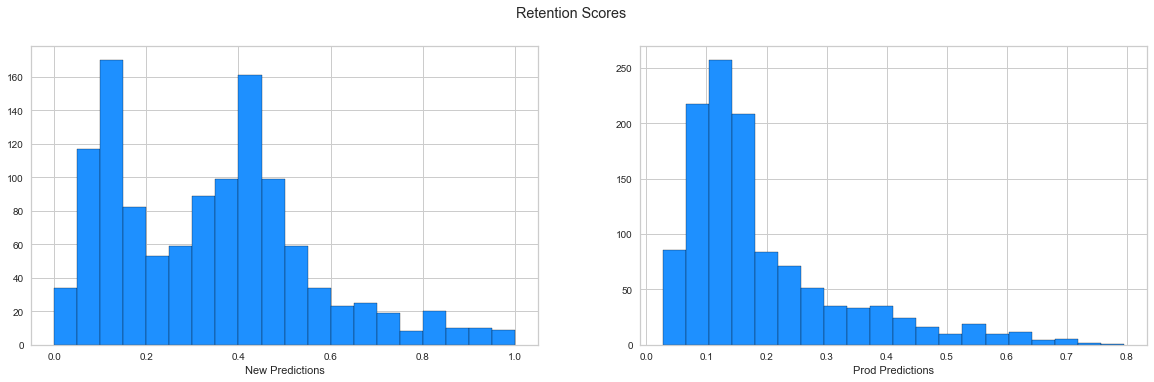

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Predictions')
ax2.set_xlabel('Prod Predictions')

fig.figure.set_figwidth(20)

### Done